In [12]:
import csv

import pandas as pd
import seaborn as sns
import glob

import sys
sys.path.insert(0, '../helpers')
import helpers

In [13]:
CONFIG = helpers.get_config()

DATA_FOLDER = CONFIG['DATA_FOLDER']
TARGET_FOLDER = CONFIG['TARGET_FOLDER']

In [14]:
df_labels = pd.read_csv('../data/raw/CXR8/CXR8/Data_Entry_2017_v2020.csv')

In [15]:
df_labels.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [16]:
# add trainset feature (bool) taken from test_list.txt and train_val_list.txt>
test_labels, train_labels = helpers.get_train_and_test_list()
test_labels[:10]

['00000003_000.png',
 '00000003_001.png',
 '00000003_002.png',
 '00000003_003.png',
 '00000003_004.png',
 '00000003_005.png',
 '00000003_006.png',
 '00000003_007.png',
 '00000013_000.png',
 '00000013_001.png']

In [17]:
files = glob.glob('../data/raw/flattened/*.png', recursive=True)

In [18]:
file_names = []
for file in files:
    file_names.append(file.split('\\')[1])

In [19]:
test_labels = [file for file in test_labels if file in file_names]
train_labels = [file for file in train_labels if file in file_names]

In [20]:
print(f'n images in testset {len(test_labels)}')
print(f'n images in trainset {len(train_labels)}')

n images in testset 25540
n images in trainset 86060


In [21]:
train_subset_labels, test_subset_labels = helpers.get_data_subset(80, 20)  # get hundred random images

## Targets
The datasets contains thousands of xrays of a human thorax. The patients can be subject to one or more of 14 illnesses, ranging from possible tumors (label = `mass`) to pneumonia. Healthy patients are labeled with `no finding`. The patients can have multiple, interconnected diagnosis, e.g. `Effusion|Infiltration`, which means that one image can have multiple targets. As this adds to the complexity of the classification task I have chosen to focus solely on images which have only one corresponding label. We take a look at the subset of images in the next few code cells.

In [22]:
df_labels['Finding Labels'].value_counts()

No Finding                                                         60361
Infiltration                                                        9547
Atelectasis                                                         4215
Effusion                                                            3955
Nodule                                                              2705
                                                                   ...  
Atelectasis|Consolidation|Edema|Effusion|Infiltration|Pneumonia        1
Atelectasis|Consolidation|Effusion|Emphysema|Mass|Pneumothorax         1
Cardiomegaly|Effusion|Pleural_Thickening|Pneumothorax                  1
Edema|Infiltration|Pneumothorax                                        1
Atelectasis|Consolidation|Mass|Pleural_Thickening|Pneumothorax         1
Name: Finding Labels, Length: 836, dtype: int64

In [23]:
labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
          'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
          'Pleural_thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']

In [24]:
df_single = df_labels[df_labels['Finding Labels'].str.contains('\|') == False]
df_single.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168


In [25]:
df_single['Finding Labels'].value_counts()

No Finding            60361
Infiltration           9547
Atelectasis            4215
Effusion               3955
Nodule                 2705
Pneumothorax           2194
Mass                   2139
Consolidation          1310
Pleural_Thickening     1126
Cardiomegaly           1093
Emphysema               892
Fibrosis                727
Edema                   628
Pneumonia               322
Hernia                  110
Name: Finding Labels, dtype: int64

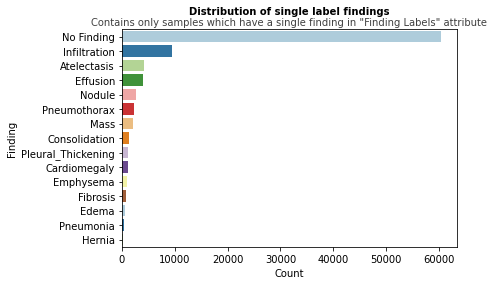

In [26]:
g = sns.countplot(data=df_single, y='Finding Labels', palette=CONFIG['COLOR_DISCRETE'],
                  order=df_single['Finding Labels'].value_counts().index)
helpers.plot_wrapper(g, 'Distribution of single label findings',
                     'Contains only samples which have a single finding in "Finding Labels" attribute', 'Count',
                     'Finding')

**Note** The graphic above shows the subset of the data which will be considered for classification. We observe that most images show `No finding` as their label. These "negative" images far surpass the "positive" classes. This could be an issue with classification later on. Strategies to deal with this unbalanced dataset will be discussed at a later stage.

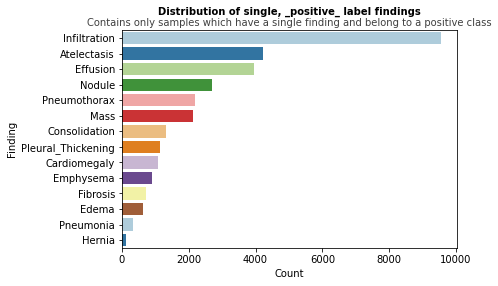

In [27]:
df_positive = df_single[df_single['Finding Labels'] != 'No Finding']
g = sns.countplot(data=df_positive, y='Finding Labels', palette=CONFIG['COLOR_DISCRETE'],
                  order=df_positive['Finding Labels'].value_counts().index)
helpers.plot_wrapper(g, 'Distribution of single, _positive_ label findings',
                     'Contains only samples which have a single finding and belong to a positive class', 'Count',
                     'Finding')

**Note** By omitting the negative class `No Finding` we get a better sense over the distribution of the 14 positive classes. We observe that `Infiltration` is the majority class in the positive subset. Other classes, like `Hernia` or `Pneumonia` build the trailing end of the distribution and thus act as minority classes.

We now extract the test- and train image file names and save them into the labels folders as `test_labels_filtered.csv` and `train_labels_filetered.csv`.
Currently all 14 targets (including "no finding") are considered.

We select two classes with a similar amount of samples to use in this challenge. The classes "Atelectasis" and "Effusion" seem to be prime candidates.

In [28]:
valid_single_label_test = []
valid_single_label_train = []

for image in df_single['Image Index']:
    if image in test_labels:
        valid_single_label_test.append(image)
    elif image in train_labels:
        valid_single_label_train.append(image)
    else:
        continue

valid_single_label_test[:10]

['00000003_001.png',
 '00000003_002.png',
 '00000003_004.png',
 '00000003_005.png',
 '00000003_006.png',
 '00000003_007.png',
 '00000003_000.png',
 '00000013_024.png',
 '00000013_033.png',
 '00000013_036.png']

In [29]:
print(f'Number of training images: {len(valid_single_label_train)}')
print(f'Number of test images: {len(valid_single_label_test)}')

Number of training images: 73057
Number of test images: 17813


In [30]:
df_train = df_single[df_single['Image Index'].isin(valid_single_label_train)][['Image Index', 'Finding Labels']]
df_train = df_train[df_train['Finding Labels'].isin(['Atelectasis', 'Effusion'])]
df_test = df_single[df_single['Image Index'].isin(valid_single_label_test)][['Image Index', 'Finding Labels']]
df_test = df_test[df_test['Finding Labels'].isin(['Atelectasis', 'Effusion'])]

In [31]:
# save lists
df_train.to_csv("../data/labels/train_labels_filtered.csv", sep=',',header=False, index=False)
df_test.to_csv("../data/labels/test_labels_filtered.csv", sep=',',header=False, index=False)